In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.datasets import fetch_covtype
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# Set the parameters for the coreset algorithm
k = 10
R = 3
epsilon = 0.1
delta = 0.1
c = 2

In [ ]:
def load_small_covtype_dataset(size=2000):
    data = fetch_covtype()
    X, y = data.data[:size], data.target[:size]
    return X, y

In [ ]:
def logistic_regression_coreset(X, y, k, c, R, epsilon, delta, M = 500):
    N = X.shape[0]
    D = X.shape[1]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k).fit(X)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_

    # Calculate sensitivity upper bounds
    m = np.zeros(N)
    for n in range(N):
        G_minus_n = np.delete(cluster_labels, n)
        cluster_sizes = np.bincount(cluster_labels)
        cluster_sizes_minus_n = np.bincount(G_minus_n, minlength=k)
        abs_diff = np.abs(cluster_sizes - cluster_sizes_minus_n)

        Z_n = cdist(X[n].reshape(1, -1), cluster_centers, 'euclidean').flatten()
        Z_minus_n = np.delete(Z_n, cluster_labels[n])
        # print("G_minus_n ", len(G_minus_n))
        # print("Z_n ", len(Z_n))
        # print("Z_minus_n ", len(Z_minus_n))
        # m[n] = N / (1 + np.sum(abs_diff * np.exp(-R * (Z_minus_n - Z_n[cluster_labels[n]])**2)))
        exponentials = np.exp(-R * (Z_minus_n - Z_n[cluster_labels[n]])**2)
        # m[n] = N / (1 + np.sum(abs_diff * exponentials))
        m[n] = N / (1 + np.sum(abs_diff[:-1] * exponentials))

    m_mean = np.mean(m)

    # Calculate coreset size

    M = int(np.ceil(c * m_mean * (D + 1) * np.log(m_mean) / (epsilon**2) + np.log(1 / delta)))

    # Calculate importance weights
    p = m / (N * m_mean)

    # Sample data for coreset
    K = np.random.multinomial(M, p)

    # Calculate coreset weights
    gamma = K / (p * M)

    # Construct coreset
    coreset_indices = np.nonzero(gamma)[0]
    coreset_weights = gamma[coreset_indices]
    coreset_X = X[coreset_indices]
    coreset_y = y[coreset_indices]

    return coreset_X, coreset_y, coreset_weights

In [ ]:
# Load a smaller chunk of the covtype dataset
X, y = load_small_covtype_dataset(size=12000)
print(X[0])
print(y[:5])

[2.596e+03 5.100e+01 3.000e+00 2.580e+02 0.000e+00 5.100e+02 2.210e+02
 2.320e+02 1.480e+02 6.279e+03 1.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
[5 5 2 2 5]


In [ ]:
coreset_X, coreset_y, coreset_weights = logistic_regression_coreset(X, y, c, k, R, epsilon, delta, M = 500)
# Train a logistic regression model on the coreset
clf = LogisticRegression(max_iter=2000);
clf.fit(coreset_X, coreset_y, sample_weight=coreset_weights);

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Test the model on the original dataset
accuracy = clf.score(X, y)
print("Accuracy:", accuracy)

Accuracy: 0.574


In [ ]:
# Lists to store results
coreset_sizes = []
coreset_accuracies = []
subset_accuracies = []
subset_sizes = [100, 500, 1000, 2000, 5000, 7000, 9000]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model on the full dataset
clf_full = LogisticRegression(max_iter=1000)
clf_full.fit(X_train, y_train);
full_accuracy = clf_full.score(X_test, y_test);

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(full_accuracy)

0.5966666666666667


In [ ]:
for size in subset_sizes:
    print("subset size:", size)
    # Construct a random subset of the training data
    if size > X_train.shape[0]:
      size = X_train.shape[0]
    subset_indices = np.random.choice(X_train.shape[0], size=size, replace=False)
    subset_X = X_train[subset_indices]
    subset_y = y_train[subset_indices]

    # Train a logistic regression model on the subset
    clf_subset = LogisticRegression(max_iter=1000);
    clf_subset.fit(subset_X, subset_y);

    # Test the model on the testing dataset
    subset_accuracy = clf_subset.score(X_test, y_test);
    subset_accuracies.append(subset_accuracy)

    # Construct the logistic regression coreset
    coreset_X, coreset_y, coreset_weights = logistic_regression_coreset(X_train, y_train, k, c, R, epsilon, delta, M=size);
    coreset_size = coreset_X.shape[0]
    coreset_sizes.append(coreset_size)

    # Train a logistic regression model on the coreset
    clf_coreset = LogisticRegression(max_iter=1000);
    clf_coreset.fit(coreset_X, coreset_y, sample_weight=coreset_weights);

    # Test the model on the testing dataset
    coreset_accuracy = clf_coreset.score(X_test, y_test);
    coreset_accuracies.append(coreset_accuracy)

subset size: 100


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 500


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 1000


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 2000


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 5000


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 7000


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

subset size: 9000


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

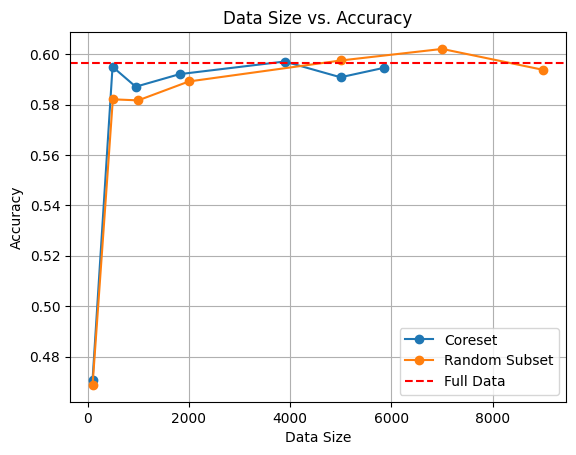

In [ ]:
from matplotlib import pyplot as plt

# Plot coreset size vs. accuracy
plt.plot(coreset_sizes, coreset_accuracies, marker='o', label='Coreset')
plt.plot(subset_sizes, subset_accuracies, marker='o', label='Random Subset')
plt.axhline(y=full_accuracy, color='r', linestyle='--', label='Full Data')
plt.xlabel('Data Size')
plt.ylabel('Accuracy')
plt.title('Data Size vs. Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.stats import multivariate_normal

In [ ]:
coreset_sizes2 = []
coreset_mmds = []
coreset_nlls = []
subset_mmds = []
subset_nlls = []

In [ ]:
import tensorflow as tf

def polynomial_ker(X, Y, c=0, d=3):
    if Y.ndim == 1:
        Y = np.expand_dims(Y, axis=1)
    if X.ndim == 1:
        X = np.expand_dims(X, axis=1)
    K = 0
    for i in range(tf.shape(X)[0]):
        for j in range(tf.shape(Y)[0]):
            K += (tf.reduce_sum((X[i,:] - Y[j, :])**2) + c)**d
    return K

# Define the MMD loss function
def mmd_loss(X, Y, c=0, d=3):

    if(X.dtype != np.float64):
      X = tf.cast(X, dtype = np.float64)
    if(Y.dtype != np.float64):
      Y = tf.cast(Y, dtype = np.float64)

    K_XX = polynomial_ker(X, X, c, d)
    K_XY = polynomial_ker(X, Y, c, d)
    K_YY = polynomial_ker(Y, Y, c, d)
    n = tf.shape(X)[0]
    m = tf.shape(Y)[0]
    n = tf.cast(n, dtype = tf.float64)
    m = tf.cast(m, dtype = tf.float64)
    print(K_XX)
    print("X_dtype", X.dtype)
    print("Y_dtype", Y.dtype)
    loss = tf.reduce_sum(K_XX) / (n * n) + tf.reduce_sum(K_YY) / (m * m) - 2 * tf.reduce_sum(K_XY) / (n * m)
    return loss

# Define the negative log likelihood loss function
def nll_loss(X, Y, c=0, d=3):

    if(X.dtype != np.float64):
      X = tf.cast(X, dtype = np.float64)
    if(Y.dtype != np.float64):
      Y = tf.cast(Y, dtype = np.float64)

    K_XX = polynomial_ker(X, X, c, d)
    K_XY = polynomial_ker(X, Y, c, d)
    K_YY = polynomial_ker(Y, Y, c, d)
    n = tf.shape(X)[0]
    m = tf.shape(Y)[0]
    n = tf.cast(n, dtype = tf.float64)
    m = n = tf.cast(m, dtype = tf.float64)
    loss = tf.reduce_sum(K_XX) / (n * n) + tf.reduce_sum(K_YY) / (m * m) - 2 * tf.reduce_sum(K_XY) / (n * m)
    return 0.5 * loss + 0.5 * np.log(n * m)

In [ ]:
for size in subset_sizes:
    # Construct a random subset of the training data
    if size > X_train.shape[0]:
        size = X_train.shape[0]
    subset_indices = np.random.choice(X_train.shape[0], size=size, replace=False);
    subset_X = X_train[subset_indices]
    subset_y = y_train[subset_indices]
    print(subset_X.shape)
    print(subset_y.shape)

    # Compute the Polynomial MMD and negative test log-likelihood of the subset
    # K = polynomial_kernel(subset_X, subset_X, degree=3)
    # L = np.diag(np.sum(K, axis=1)) - K
    # mmd = np.trace(np.dot(np.dot(K, L), K))
    mmd = mmd_loss(subset_X, subset_y)
    subset_nll = nll_loss(subset_X, subset_y)

    # Train a logistic regression model on the subset
    clf_subset = LogisticRegression(max_iter=1000);
    clf_subset.fit(subset_X, subset_y);

    # Test the model on the testing dataset
    subset_accuracy = clf_subset.score(X_test, y_test);
    subset_mmds.append(mmd);
    subset_nlls.append(subset_nll);

    # Construct the logistic regression coreset
    coreset_X, coreset_y, coreset_weights = logistic_regression_coreset(X_train, y_train, k, c, R, epsilon, delta, M=size);
    coreset_size = coreset_X.shape[0]
    coreset_sizes2.append(coreset_size)

    # Compute the Polynomial MMD and negative test log-likelihood of the coreset
    mmd = mmd_loss(coreset_X, coreset_y);
    coreset_nll = nll_loss(coreset_X, coreset_y);

    # Train a logistic regression model on the coreset
    clf_coreset = LogisticRegression(max_iter=1000)
    clf_coreset.fit(coreset_X, coreset_y, sample_weight=coreset_weights);

    # Test the model on the testing dataset
    coreset_accuracy = clf_coreset.score(X_test, y_test);
    coreset_mmds.append(mmd);
    coreset_nlls.append(coreset_nll);

In [ ]:
# Scale the values of the negative log-likelihood by a factor of 100
# subset_nlls = [nll /100 for nll in subset_nlls]
# coreset_nlls = [nll /100 for nll in coreset_nlls]
print(subset_nlls)
print(coreset_nlls)
print(subset_mmds)
print(coreset_mmds)

[<tf.Tensor: shape=(), dtype=float64, numpy=0.00046051701859880915>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0006214608098422191>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0006907755278982137>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0007600902459542082>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008517193191416237>, <tf.Tensor: shape=(), dtype=float64, numpy=0.000885366542803745>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0009104979856318357>]
[<tf.Tensor: shape=(), dtype=float64, numpy=0.00046051701859880915>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0006186208623900494>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0006863803391452955>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0007491087593534876>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008261784679514752>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008512381634419014>, <tf.Tensor: shape=(), dtype=float64, numpy=0.0008669055540725484>]
[<tf.Tensor: shape=(), dtype=float64, numpy=0.0>, <tf.Tenso

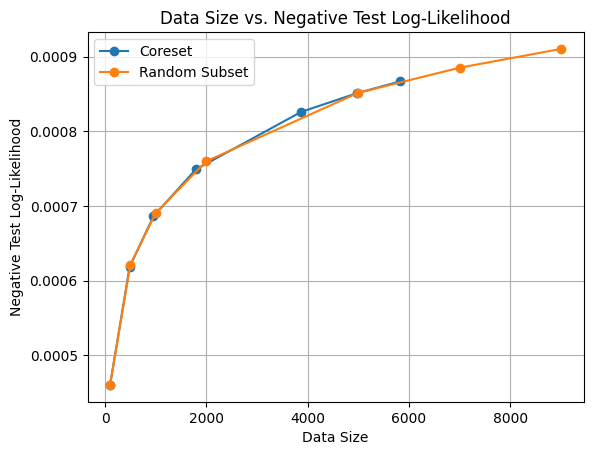

In [ ]:
# Plot coreset size vs. negative test log-likelihood
plt.plot(coreset_sizes2, coreset_nlls, marker='o', label='Coreset')
plt.plot(subset_sizes, subset_nlls, marker='o', label='Random Subset')
plt.xlabel('Data Size')
plt.ylabel('Negative Test Log-Likelihood')
plt.title('Data Size vs. Negative Test Log-Likelihood')
plt.legend()
plt.grid()
plt.show()